In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
import h5py
import copy

# draw the dark hole regions
from skimage.draw import draw

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 03/06/2021 22:52:45


### OAP1: SN2

In [2]:
oap_name = 'OAP1'
sn_label = 'SN2'
h5file = h5py.File(sn_label+'.datx') # must be .datx filetype for hdf5
    
# Get surface and attributes
surface_snum = list(h5file['Data']['Surface'])[0] # pull serial number value
surface_raw = h5file['Data']['Surface'][surface_snum][()]
surface_attrs = h5file['Data']['Surface'][surface_snum].attrs

# Build mask from "No Data" attributes
mask_raw = np.ones_like(surface_raw).astype(bool)
mask_raw[surface_raw == surface_attrs['No Data']] = 0
surface_raw[~mask_raw] = 0 # Apply mask to surface (will always be true)

# compile surface data information
wavelen = surface_attrs['Wavelength'][0] * u.m
latres = surface_attrs['X Converter'][0][2][1] * u.m/u.pix
surfunit = surface_attrs['Unit'][0]

In [3]:
# converting surface units from fringes
set_surf_unit = u.nm # set surface unit

print('initial surf unit = {0}'.format(surfunit))
if surfunit == b'Fringes':
    scale_factor = surface_attrs['Interferometric Scale Factor'][0]
    surface_raw = surface_raw * scale_factor * wavelen.to(set_surf_unit)
else:
    surface_raw = surface_raw.to(set_surf_unit)
    
print('Converted surface units to {0}'.format(surface_raw.unit))

initial surf unit = b'Fringes'
Converted surface units to nm


In [4]:
# set the clear aperture range
ca = 80 # set desired clear aperture
diam_ca100 = 15.900*u.mm # defined in the docs
npix_rca = int((diam_ca100.to(u.m)*(ca/100)/latres).value/2)

# find the center
rcen = int(mask_raw.shape[0]/2)
ccen = int(mask_raw.shape[1]/2)
# crop from center 
ca_surf = copy.copy(surface_raw)
ca_surf = ca_surf[rcen-npix_rca:rcen+npix_rca, ccen-npix_rca:ccen+npix_rca]

# build the CA mask
if ca_surf.shape[0]%2 == 0:
    xy = np.linspace(-npix_rca, npix_rca, ca_surf.shape[0], endpoint=False)
else:
    xy = np.linspace(-npix_rca, npix_rca, ca_surf.shape[0], endpoint=True)
xx,yy = np.meshgrid(xy,xy)
ca_mask = xx**2 + yy**2 <= npix_rca**2

# apply clear aperture mask to the surface
ca_surf *= ca_mask

# check if there are any bad pixels in the clear aperture
npix_bad = np.sum(np.isnan(ca_surf[ca_mask==1]))
print('Number of bad pixels present: {0}'.format(npix_bad))

Number of bad pixels present: 0


Text(0.5, 1.0, 'OAP1 SN2, 80% CA, raw')

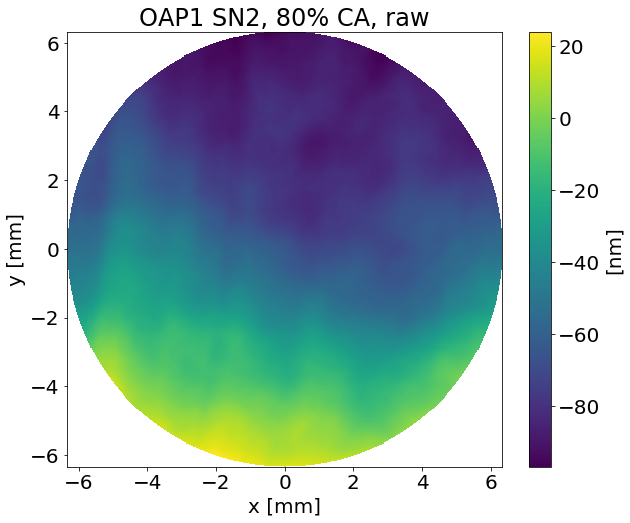

In [5]:
# show the cropped aperture surface
surf_nan = copy.copy(ca_surf)
surf_nan[~ca_mask] = np.nan

# set the axis scaling
xy_min = (np.min(xy)*latres*u.pix).to(u.mm)
xy_max = (np.max(xy)*latres*u.pix).to(u.mm)
axis_extent = [xy_min.value, xy_max.value,
               xy_min.value, xy_max.value]

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[10,8], facecolor='white')
plt.imshow(surf_nan.value, origin='lower',
           extent=axis_extent)
plt.colorbar().set_label('[{0}]'.format(surf_nan.unit))
plt.xlabel('x [{0}]'.format(str(xy_min.unit)))
plt.ylabel('y [{0}]'.format(str(xy_max.unit)))
plt.title('{0} {1}, {2}% CA, raw'.format(oap_name, sn_label, ca))

In [6]:
# Post-processing Zernike removal
from model_kit import zernike as zern
z_tot = 6

# convert surface data to phase
k_num = wavelen.to(ca_surf.unit)/(2*np.pi*u.radian)
surf_phase = ca_surf/k_num
# remove the Zernikes
z_map, z_weight = zern.calc_zernike_proj(data=surf_phase, 
                                         nterms=z_tot, 
                                         mask_full=ca_mask)
surf_fix_phase = copy.copy(surf_phase)
for j in range(0, z_tot):
    surf_fix_phase = surf_fix_phase - (z_map[j]*z_weight[j])

# convert back to surface
surf_fix = surf_fix_phase*k_num

# zero mean
surf_mean = np.mean(surf_fix[ca_mask==True])
surf_fix = surf_fix - surf_mean

In [7]:
def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))
ca_rms = rms(surf_fix[ca_mask==1])
ca_rms

<Quantity 5.59571963 nm>

Text(0.5, 1.0, 'OAP1 SN2, 80% CA, RMS=5.596 nm')

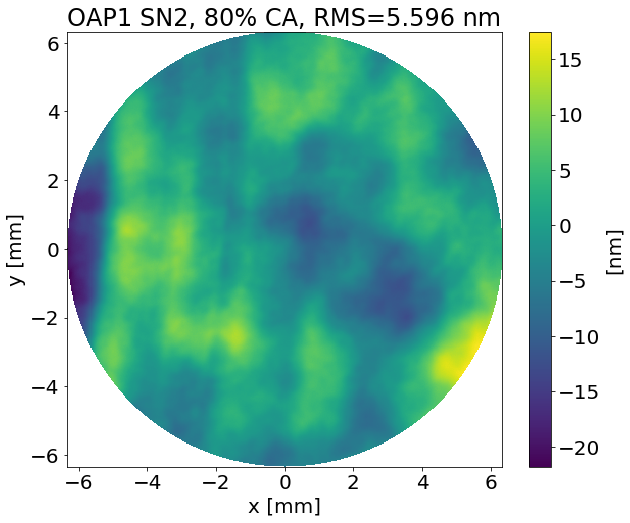

In [8]:
# plot real quick
ca_rms = rms(surf_fix[ca_mask==1])
surf_nan = copy.copy(surf_fix)
surf_nan[~ca_mask] = np.nan

xy_min = (np.min(xy)*latres*u.pix).to(u.mm)
xy_max = (np.max(xy)*latres*u.pix).to(u.mm)
axis_extent = [xy_min.value, xy_max.value,
               xy_min.value, xy_max.value]

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[10,8], facecolor='white')
plt.imshow(surf_nan.value, origin='lower',
           extent=axis_extent)
plt.colorbar().set_label('[{0}]'.format(surf_fix.unit))
plt.xlabel('x [{0}]'.format(str(xy_min.unit)))
plt.ylabel('y [{0}]'.format(str(xy_max.unit)))
plt.title('{0} {1}, {2}% CA, RMS={3:.3f}'.format(oap_name, sn_label, ca, ca_rms))

In [9]:
# save the post-processed file in FITS format
fhdr = fits.Header()
fhdr.set('opt_name', oap_name + '_' + sn_label, 
         'Optical element name')
fhdr.set('wavelen', wavelen.value, 
         'Wavelength used in measurement [{0}]'.format(str(wavelen.unit)))
fhdr.set('latres', latres.value, 
         'Surface pixscale [{0}]'.format(str(latres.unit)))
fhdr.set('OD', diam_ca100.value,
         'optical diameter [{0}]'.format(diam_ca100.unit))
fhdr.set('CA', ca,
         'Clear aperture percentage')
fhdr.set('diam_ca', (ca_mask.shape[0]*(latres*u.pix).to(u.mm)).value,
          'Clear aperture diameter [{0}]'.format(diam_ca100.unit))

# write the fits file
fits_filename = oap_name + '_' + sn_label + '_{0}CA_pp'.format(ca)
# write the mask file
fits.writeto(filename=fits_filename+'_mask.fits',
             data=ca_mask.astype(int),
             header=fhdr,
             overwrite=True)

# add more to the header for the surface file
fhdr.set('sunit', str(surf_fix.unit),
         'Measured surface units')
fhdr.set('wfe_rms', ca_rms.value,
         'Surface rms at clear aperture [{0}]'.format(str(ca_rms.unit)))
fhdr.set('z_rem', z_tot,
         'Number of Zernikes removed (Noll)')
fits.writeto(filename=fits_filename+'_surf.fits',
             data=surf_fix.value,
             header=fhdr,
             overwrite=True)